In [1]:
import os
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import nibabel as nib

import read_roi
from read_roi import read_roi_zip

from collections import OrderedDict

import pathlib
from pyometiff import OMETIFFReader

import skimage as ski
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

from scipy import sparse
from scipy.sparse import linalg

In [2]:
#https://github.com/zmzhang/airPLS/blob/master/airPLS.py

def baseline_arPLS(y, ratio=1e-8, lam=800, niter=5000, full_output=True):
    L = len(y)
    diag = np.ones(L - 2)
    D = sparse.spdiags([diag, -2*diag, diag], [0, -1, -2], L, L - 2)
    H = lam * D.dot(D.T)  # The transposes are flipped w.r.t the Algorithm on pg. 252
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    crit = 1
    count = 0

    while crit > ratio:
        z = linalg.spsolve(W + H, W * y)
        d = y - z
        dn = d[d < 0]

        m = np.mean(dn)
        s = np.std(dn)

        w_new = 1 / (1 + np.exp(2 * (d - (2*s - m))/s))

        crit = norm(w_new - w) / norm(w)

        w = w_new
        W.setdiag(w)  # Do not create a new matrix, just update diagonal values

        count += 1

        if count > niter:
            print('Maximum number of iterations exceeded')
            break

    if full_output:
        info = {'num_iter': count, 'stop_criterion': crit}
        return z, d, info
    else:
        return z

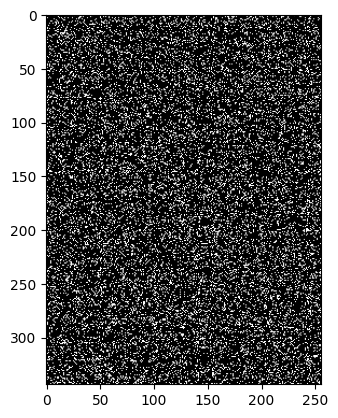

In [3]:
import random

empty_header = nib.Nifti1Header()
xform = np.eye(4)

mask_random_shape = ((344, 256))
random_masks = np.zeros(mask_random_shape)
  
rangeX = (0, mask_random_shape[0])
rangeY = (0, mask_random_shape[1])
sparticity = 20
qty = sparticity*(mask_random_shape[0]*mask_random_shape[1])/100  # or however many points you want

randPoints = []
i = 0
while i<qty:
    x = random.randrange(*rangeX)
    y = random.randrange(*rangeY)
    randPoints.append((x,y))
    i += 1
    random_masks[x][y] = 1;

plt.imshow(random_masks, cmap='gray', vmin=0, vmax=1)


In [4]:
import pandas as pd

df = pd.DataFrame()
df_norm = pd.DataFrame()

dir_path = "/Volumes/LaCie/projets_CALIM/optim_new_analysis/GLUT_DNQX/"

all_spectra_arPLS_select_cum = []
all_spectra_arPLS_random = np.zeros(150)
all_spectra_arPLS_select = np.zeros(150)
all_spectra_arPLS_background = np.zeros(150)

all_spectra_random = np.zeros(150)
all_spectra_select = np.zeros(150)

all_spectra_arPLS_normalized = np.zeros(150)
all_spectra_arPLS_substrated_normalized = np.zeros(150)

list_date = os.listdir(dir_path)

for date in list_date:
    date_exp = date.split('-')
    print("date = ",date)
    date_exp_cor = str(date_exp[2])+str(date_exp[1])+str(date_exp[0])
    print("date corrige = ",date_exp_cor)

    list_exp = os.listdir(dir_path+date)

    for dir in list_exp:
        exp_dir = dir.split('_')
        #if (exp_dir[0]=='230721' and exp_dir[1]=='3'):
        
        if (exp_dir[0]==date_exp_cor):
            print(exp_dir)

            num_exp = exp_dir[1]
    
            img_ometif_name = dir_path + '/' + str(date) + '/'  + str(dir) + '/' + str(dir) + "_MMStack_Pos0.ome.tif"
            img_fpath = pathlib.Path(img_ometif_name)
    
            reader = OMETIFFReader(fpath=img_fpath)
            img_array, metadata, xml_metadata = reader.read()
            img_array_flip = np.swapaxes(img_array,2,0)
            print(img_array_flip.shape)

            ome_to_nii_name = dir_path + '/' + str(date) + '/'  + str(dir) + '/' + str(dir) + "_MMStack_Pos0_mean.nii.gz"
            ome_to_nii_name_ds = dir_path + '/' + str(date) + '/'  + str(dir) + '/' + str(dir) + "_MMStack_Pos0_mean_ds.nii.gz"

            print(ome_to_nii_name)
            
            img_array_flip_mean = np.mean(img_array_flip[:,:,:], axis = 2)
            img_array_flip_mean_downscaled = downscale_local_mean(img_array_flip_mean, (2, 2) )
            
            stack_average_ome_to_nii = nib.Nifti1Image(img_array_flip_mean, xform)
            #nib.save(stack_average_ome_to_nii, ome_to_nii_name)
            stack_average_ome_to_nii_ds = nib.Nifti1Image(img_array_flip_mean_downscaled, xform)
            #nib.save(stack_average_ome_to_nii_ds, ome_to_nii_name_ds)
    
            img_array_downscaled = downscale_local_mean(img_array_flip, (2, 2, 10) )
            img_array_downscaled_res = np.reshape(img_array_downscaled, (img_array_downscaled.shape[0], img_array_downscaled.shape[1], 1, img_array_downscaled.shape[2]))
    
            ome_to_nii_name_nlm = dir_path + '/' + str(date) + '/'  + str(dir) + '/' + str(dir) + "_MMStack_Pos0_nlm_2_2_10.nii.gz"
            
            convert_ome_to_nii_downscaled = nib.Nifti1Image(img_array_downscaled_res, xform)
            print(img_array_downscaled_res.shape)
            #nib.save(convert_ome_to_nii_downscaled, ome_to_nii_name_nlm)
    
            zip_file = dir_path + '/' + str(date) + '/'  + str(dir) + "/Rois/Rois.zip"
            xform_mask = np.eye(4)
            hdr = nib.Nifti1Header()
            
            if (os.path.isfile(zip_file)):
                my_rois = read_roi.read_roi_zip(zip_file)
     
                mask_shape = ((688, 512))
    
                polygon_list = []
                all_masks = np.zeros(mask_shape)
                
                mask_number = 0
    
                for i in my_rois.keys():
    
                    mask_number = mask_number + 1
                    new_polygon = []
                    for n in range(0,len(my_rois[i]['x'])):
                        new_polygon.append([my_rois[i]['x'][n],my_rois[i]['y'][n]])
                
                    polygon_list.append(new_polygon)
    
                    mask = ski.draw.polygon2mask(mask_shape, polygon_list[mask_number-1])
                    mask.astype(int)
    
                    #mask_downscaled = downscale_local_mean(mask, (2, 2) )
                    mask_downscaled = rescale(mask, 0.5, anti_aliasing=False)
                    print(mask_downscaled.shape)
    
                    mask_labeled = mask.astype(int) * mask_number
                    
                    convert_polygon_fiji_to_mask_nii = nib.Nifti1Image(mask_downscaled, xform_mask,hdr)
                    mask_to_nii_name = dir_path + '/' + str(date) + '/'  + str(dir) + '/' + str(dir) + "_MMStack_Pos0_mask" + str(mask_number) + ".nii.gz"
                    #nib.save(convert_polygon_fiji_to_mask_nii, mask_to_nii_name)
    
                    mask_downscaled_t = np.dstack([mask_downscaled]*150)
    
                    random_mask_t = np.dstack([random_masks]*150)
    
                    mask_flat=np.concatenate(mask_downscaled_t,axis=0)
                    timeserie_flat=np.concatenate(img_array_downscaled,axis=0)
                    randommask_flat=np.concatenate(random_mask_t,axis=0)
                    
                    print(timeserie_flat.shape,mask_flat.shape)
    
                    timeserie_flat_masked = np.multiply(timeserie_flat, mask_flat)
                    timeserie_flat_masked_select = timeserie_flat_masked[~np.all(timeserie_flat_masked == 0, axis=1)]
                    randommask_flat_masked = np.multiply(timeserie_flat, randommask_flat)
                    
                    mean_timeserie_flat_masked_select = timeserie_flat_masked_select.mean(axis=0)
                    mean_timeserie_flat = timeserie_flat.mean(axis=0)
                    mean_timeserie_flat_random = randommask_flat_masked.mean(axis=0)

                    print("mean value 10->50  = ", timeserie_flat_masked_select.shape)
                    
                    _, spectra_arPLS_select, info = baseline_arPLS(mean_timeserie_flat_masked_select, ratio=1e-5, lam=10, niter=5000,
                                             full_output=True)
                    _, spectra_arPLS, info = baseline_arPLS(mean_timeserie_flat, ratio=1e-5, lam=10, niter=5000,
                                             full_output=True)
                    _, spectra_arPLS_random, info = baseline_arPLS(mean_timeserie_flat_random, ratio=1e-5, lam=10, niter=5000,
                                             full_output=True)
                    _, spectra_substracted_arPLS, info = baseline_arPLS(mean_timeserie_flat_masked_select - mean_timeserie_flat_random, ratio=1e-5, lam=10, niter=5000,
                                             full_output=True)

                    figure_arpls_name = dir_path + '/' + str(date) + '/'  + str(dir) + '/' + str(dir) + "_mask_arpls_clean_" + str(mask_number) + ".png"
                    fig2, ax2 = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
                    ax2.plot(spectra_substracted_arPLS[1:149], 'g-', label='neuron sub background arpls')
                    ax2.plot(spectra_arPLS_random[1:149], 'b-', label='background arpls')
                    
                    ax2.legend()
                    
                    fig2.savefig(figure_arpls_name)   # save the figure to file
                    plt.close(fig2)

                    figure_arpls_norm_name = dir_path + '/' + str(date) + '/'  + str(dir) + '/' + str(dir) + "_mask_arpls_NORM_" + str(mask_number) + ".png"
                    spectra_arPLS_normalized_select = spectra_arPLS_select / (mean_timeserie_flat_masked_select - spectra_arPLS_select)

                    spectra_arPLS_sub_normalized_select = spectra_substracted_arPLS / ( mean_timeserie_flat_masked_select - mean_timeserie_flat_random - spectra_substracted_arPLS)

                    fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
                    ax.plot(spectra_arPLS_normalized_select[:], 'g-',  label='neuron sub background arpls normalized')
    
                    fig.savefig(figure_arpls_norm_name)   # save the figure to file
                    plt.close(fig)

                    figure_name = dir_path + '/' + str(date) + '/'  + str(dir) + '/' + str(dir) + "_mask" + str(mask_number) + ".png"
                    print(figure_name)
                    
                    fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
                    ax.plot(mean_timeserie_flat_masked_select[:], 'r-',  label='neuron in')
                    #ax.plot(mean_timeserie_flat[:], 'g-', label='neuron out')
                    ax.plot(mean_timeserie_flat_random[:], 'b-', label='background')
                    ax.plot(mean_timeserie_flat_masked_select[:] - mean_timeserie_flat_random[:], 'g-', label='neuron sub background')
                    ax.plot(mean_timeserie_flat_masked_select[:] - mean_timeserie_flat_random[:] - spectra_substracted_arPLS[:], 'k--', label='fit arpls')
                    ax.legend()
                    fig.savefig(figure_name)   # save the figure to file
                    plt.close(fig)

                    new_roi=str(date)+"_" + str(dir) + "_ROI" + str(mask_number) 
                    df[new_roi] = spectra_arPLS_select.tolist()

                    all_spectra_arPLS_select_cum = np.concatenate((all_spectra_arPLS_select_cum, spectra_arPLS_sub_normalized_select),axis=None)
                    all_spectra_arPLS_substrated_normalized  = np.add(all_spectra_arPLS_substrated_normalized,spectra_arPLS_sub_normalized_select)

                    all_spectra_arPLS_background = np.add(all_spectra_arPLS_background,spectra_arPLS)
                    all_spectra_arPLS_random = np.add(all_spectra_arPLS_random,spectra_arPLS_random)
    
                    all_spectra_select  = np.add(all_spectra_select,mean_timeserie_flat_masked_select)
                    all_spectra_random = np.add(all_spectra_random,mean_timeserie_flat_random)
    
                    all_masks = np.add(all_masks,mask_labeled)

                    df_norm[new_roi] = all_spectra_arPLS_substrated_normalized.tolist()
    
                convert_polygon_fiji_to_all_masks_nii = nib.Nifti1Image(all_masks, xform_mask,hdr)
                all_masks_to_nii_name = dir_path + '/' + str(date) + '/'  + str(dir) + '/' + str(dir) + "_MMStack_Pos0_all_masks.nii.gz"
                #nib.save(convert_polygon_fiji_to_all_masks_nii, all_masks_to_nii_name)
                


date =  04-04-23
date corrige =  230404
['230404', '9']
key not found 'NoneType' object has no attribute 'iter'
Key not found: 'NoneType' object has no attribute 'iter'
(688, 512, 1500)
/Volumes/LaCie/projets_CALIM/optim_new_analysis/GLUT_DNQX//04-04-23/230404_9/230404_9_MMStack_Pos0_mean.nii.gz
(344, 256, 1, 150)
(344, 256)
(88064, 150) (88064, 150)
mean value 10->50  =  (349, 150)
/Volumes/LaCie/projets_CALIM/optim_new_analysis/GLUT_DNQX//04-04-23/230404_9/230404_9_mask1.png
(344, 256)
(88064, 150) (88064, 150)
mean value 10->50  =  (507, 150)
Maximum number of iterations exceeded
/Volumes/LaCie/projets_CALIM/optim_new_analysis/GLUT_DNQX//04-04-23/230404_9/230404_9_mask2.png
(344, 256)
(88064, 150) (88064, 150)
mean value 10->50  =  (424, 150)
/Volumes/LaCie/projets_CALIM/optim_new_analysis/GLUT_DNQX//04-04-23/230404_9/230404_9_mask3.png
(344, 256)
(88064, 150) (88064, 150)
mean value 10->50  =  (341, 150)
/Volumes/LaCie/projets_CALIM/optim_new_analysis/GLUT_DNQX//04-04-23/230404_9/2

/var/folders/57/fz9f573j4j3539hd3vxk7w6c0000gp/T/ipykernel_73475/1003692451.py:21: RuntimeWarning: overflow encountered in exp
  w_new = 1 / (1 + np.exp(2 * (d - (2*s - m))/s))


/Volumes/LaCie/projets_CALIM/optim_new_analysis/GLUT_DNQX//04-04-23/230404_5/230404_5_mask1.png
(344, 256)
(88064, 150) (88064, 150)
mean value 10->50  =  (502, 150)
/Volumes/LaCie/projets_CALIM/optim_new_analysis/GLUT_DNQX//04-04-23/230404_5/230404_5_mask2.png
(344, 256)
(88064, 150) (88064, 150)
mean value 10->50  =  (501, 150)
/Volumes/LaCie/projets_CALIM/optim_new_analysis/GLUT_DNQX//04-04-23/230404_5/230404_5_mask3.png


(1050,)


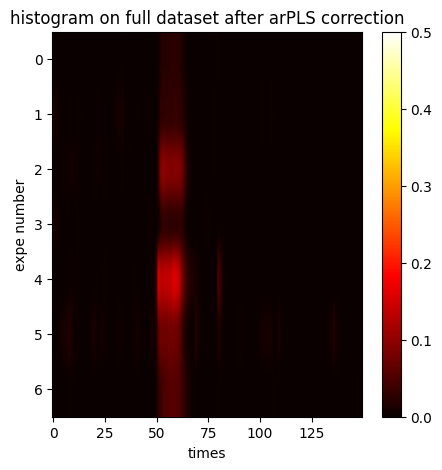

In [5]:
fig=plt.figure(figsize=(5,5))  
plt.title("histogram on full dataset after arPLS correction")
plt.xlabel('times')
plt.ylabel('expe number')

width=150
# Paramètres pour l'échelle de couleur
vmin = 0
vmax = .5

all_spectra_arPLS_select_cum[0:20]=0
print(all_spectra_arPLS_select_cum.shape)
expe = plt.imshow(all_spectra_arPLS_select_cum.reshape(all_spectra_arPLS_select_cum.shape[0]//width,width), cmap='hot', aspect='auto', vmin=vmin, vmax=vmax)
fig.colorbar(expe)

plt.savefig(dir_path +'heatmap.pdf')

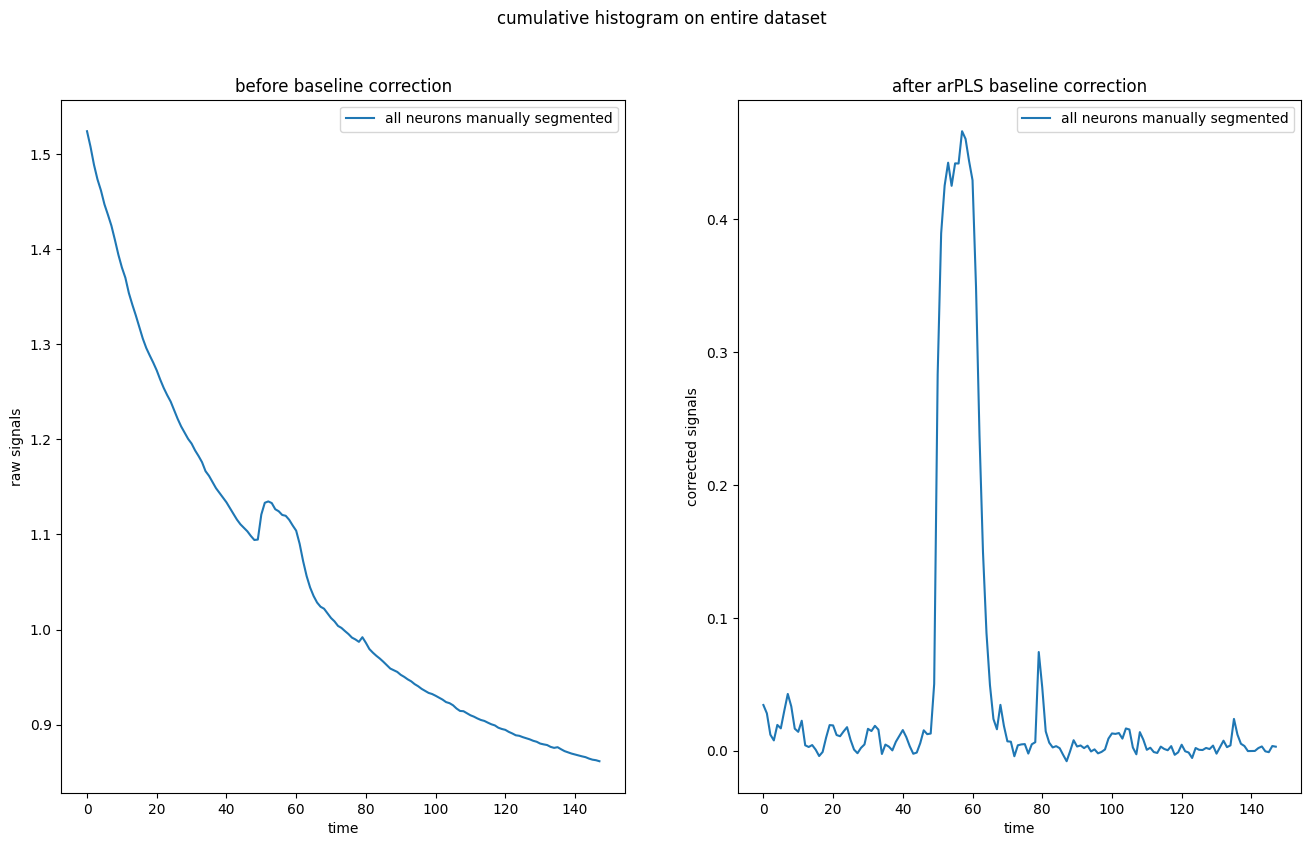

In [6]:
fig, axs = plt.subplots(1,2,figsize=(16,9) )

facto_s = np.percentile(all_spectra_select[1:149],50)
axs[0].plot(all_spectra_select[1:149]/facto_s, label='all neurons manually segmented')

facto_b = np.percentile(all_spectra_random[1:149],50)
axs[0].set_title('before baseline correction')
axs[0].set_ylabel('raw signals')
axs[0].set_xlabel('time')
axs[0].legend()

axs[1].plot(all_spectra_arPLS_substrated_normalized[1:149], label='all neurons manually segmented')
axs[1].set_title('after arPLS baseline correction')
axs[1].set_ylabel('corrected signals')
axs[1].set_xlabel('time')
axs[1].legend()

fig.suptitle('cumulative histogram on entire dataset')
plt.show()

/var/folders/57/fz9f573j4j3539hd3vxk7w6c0000gp/T/ipykernel_73475/3158848988.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig3.show()


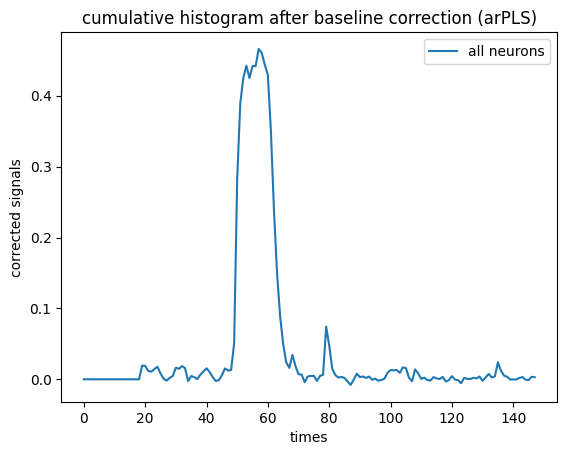

In [7]:
fig3, ax3 = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis

all_spectra_arPLS_substrated_normalized[0:20]=0
ax3.plot(all_spectra_arPLS_substrated_normalized[1:149], label='all neurons')
plt.xlabel('times')
plt.ylabel('corrected signals')
plt.title('cumulative histogram after baseline correction (arPLS)')
ax3.legend()
fig3.show()

plt.savefig(dir_path +'hist_cum.pdf')

In [8]:
#display the DataFrame
df_norm

,04-04-23_230404_9_ROI1,04-04-23_230404_9_ROI2,04-04-23_230404_9_ROI3,04-04-23_230404_9_ROI4,04-04-23_230404_5_ROI1,04-04-23_230404_5_ROI2,04-04-23_230404_5_ROI3
0,0.021881,0.041553,0.048575,0.068434,0.068741,0.074257,0.077331
1,0.011522,0.023104,0.023008,0.033183,0.033587,0.033687,0.034370
2,0.006904,0.017206,0.020106,0.025683,0.026737,0.026591,0.028089
3,0.002503,0.005248,0.004987,0.004784,0.006603,0.011452,0.012058
4,0.000513,0.000920,0.001792,0.001365,0.001556,0.008756,0.007736
...,...,...,...,...,...,...,...
145,0.000259,0.001335,0.001084,0.000991,-0.000064,-0.000020,-0.000476
146,-0.000241,-0.000384,-0.000619,-0.000812,-0.000122,0.000163,-0.001114
147,-0.000358,-0.000243,-0.000549,-0.000760,-0.000470,-0.000657,0.003506
148,0.001091,0.002198,0.001217,0.000828,0.000703,0.001051,0.003013


In [ ]:
df.to_csv(dir_path + '/results_raw.csv', index=False) 
df_norm.to_csv(dir_path + '/results_norm.csv', index=False) 